# LLM - Bielik - Fine tuning - part II

In [ ]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [14]:
import matplotlib.pyplot as plt

In [5]:
# from huggingface_hub import notebook_login
# 
# notebook_login()

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "speakleash/Bielik-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [10]:
def format_for_output(data):
    text = f"### Question: {data['question']}\n ### Answer: {data['answer']}"
    return text

In [11]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(format_for_output(prompt))

In [8]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='ft_output_data/data_ft_20240817_213654_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='ft_output_data/data_ft_20240817_213654_eval.jsonl', split='train')

Generating train split: 798 examples [00:00, 79517.59 examples/s]
Generating train split: 226 examples [00:00, 28282.39 examples/s]


In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 226/226 [00:00<00:00, 2230.77 examples/s]


In [13]:
tokenized_train_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 798
})

1024


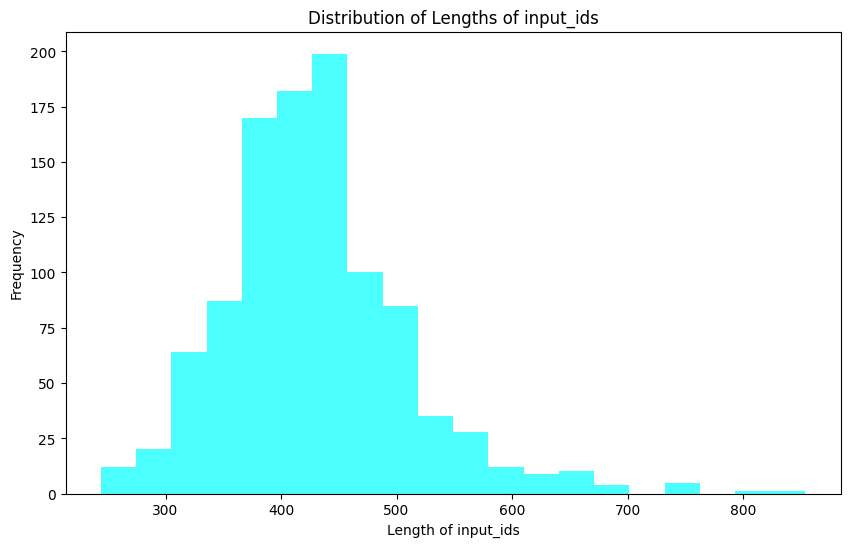

In [16]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='cyan')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)